# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Загружаем библиотеки

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

### Загружаем данные

In [2]:
data_one = pd.read_csv('/datasets/geo_data_0.csv')
data_two = pd.read_csv('/datasets/geo_data_1.csv')
data_three = pd.read_csv('/datasets/geo_data_2.csv')

### Проводим исследование входных данных

Напишем небольшую функцию, которая поможет посмотреть основную инфу о входных данных

In [3]:
def analyze_dataset(data, name):
    print(name, 'состоит из: ', data.shape[0], 'строк и ', data.shape[1], 'столбцов\nКоличество дубликатов:', data.duplicated().sum())
    print()
    print(data.info())
    print()
    display(data.describe(include='all').transpose())
    print()
    display(data.head(10))
    print()
    data.hist(figsize=(10, 10), bins = 50, color='black');
    plt.show()
    #data['product'] = (data['product'] - data['product'].mean()) / data['product'].std()
    #data = data.drop(columns='product')
    corr = data.corr()
    sns.heatmap(corr, annot=True)
    plt.show()

Посмотрим данные первого региона

Первый регион состоит из:  100000 строк и  5 столбцов
Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99990,TtcGQ,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,0.500419,0.871832,-1.408605,-0.07258,0.50236,1.073581,2.362331
f1,100000.0,NaN,NaN,NaN,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,NaN,NaN,NaN,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.00379
product,100000.0,NaN,NaN,NaN,92.5,44.288691,0.0,56.497507,91.849972,128.564089,185.364347


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


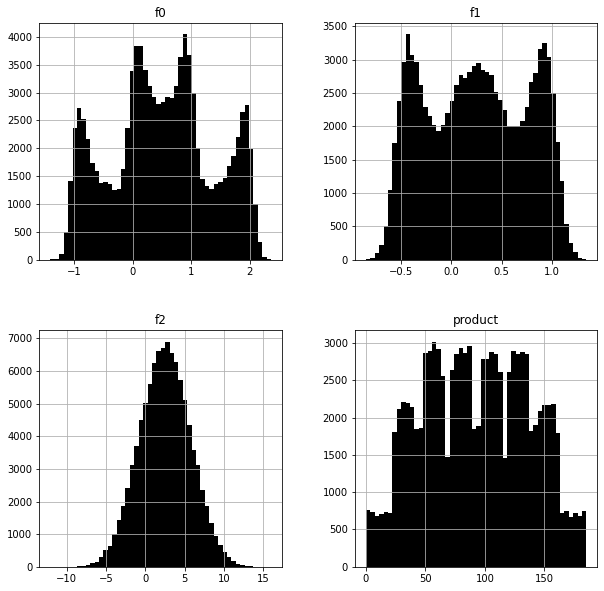

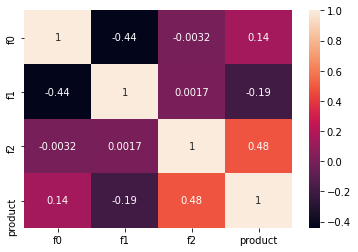

In [4]:
analyze_dataset(data_one, 'Первый регион')

Посмотрим данные второго региона

Второй регион состоит из:  100000 строк и  5 столбцов
Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99996,LHZR0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,NaN,NaN,NaN,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,NaN,NaN,NaN,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,NaN,NaN,NaN,68.825,45.944423,0.0,26.953261,57.085625,107.813044,137.945408


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


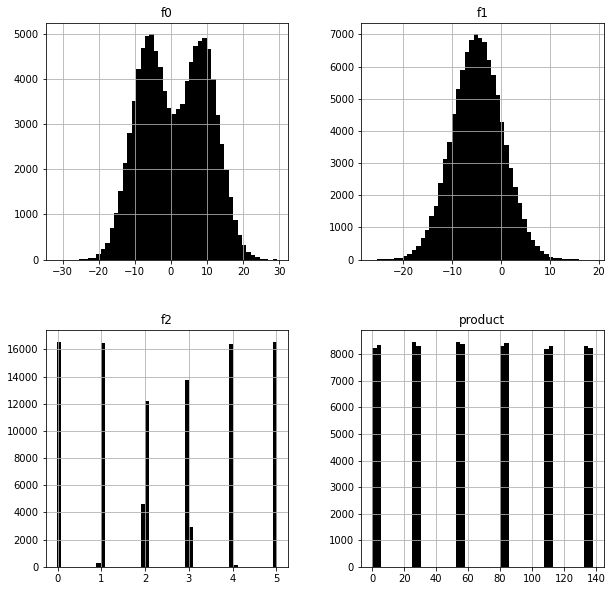

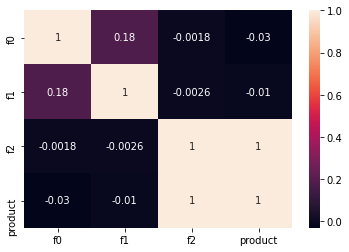

In [5]:
analyze_dataset(data_two, 'Второй регион')

Посмотрим данные третьего региона

Третий регион состоит из:  100000 строк и  5 столбцов
Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99996,KUPhW,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,NaN,NaN,NaN,-0.002081,1.730417,-7.08402,-1.17482,-0.009482,1.163678,7.844801
f2,100000.0,NaN,NaN,NaN,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,NaN,NaN,NaN,95.0,44.749921,0.0,59.450441,94.925613,130.595027,190.029838


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


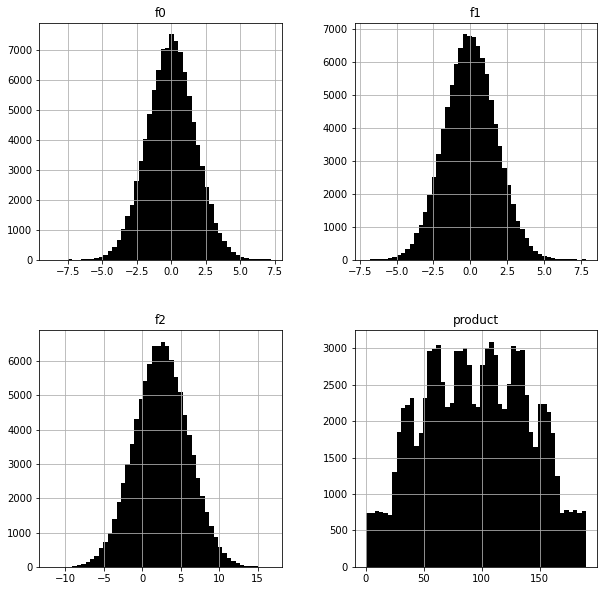

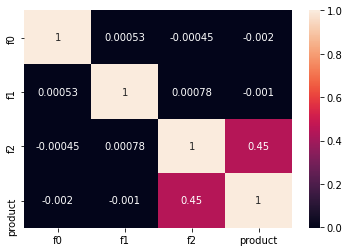

In [6]:
analyze_dataset(data_three, 'Третий регион')

### Выводы

Исходя из полученной информации можно сделать следующие выводы:
<br>
1. Данные всех трех выборок структурированы одинаково, имеют идентичное количество строк и столбцов
2. В данных отсутствуют пропуски и дубликаты
3. Нам не требуется применять порядковое кодирование т.к. признаки уже являются численными
<br>
<br>
id — уникальный идентификатор скважины;
<br>
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
<br>
product — объём запасов в скважине (тыс. баррелей).

## Обучение и проверка модели

### Разобьем данные на обучающую и валидационную выборки в соотношении 75:25

Будем использовать встроенную функцию <b>train_test_split</b> модуля <b>sklearn.model_selection</b> для разделения данных каждого региона на обучающую и валидационную выборки в соотношении 75:25

In [7]:
def split_data(data):
    data_train, data_valid = train_test_split(data, test_size=.25, random_state=12345)
    
    features_train = data_train.drop(['id', 'product'], axis = 1)
    target_train = data_train['product']
    features_valid = data_valid.drop(['id', 'product'], axis = 1)
    target_valid = data_valid['product']
    
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    print('Исходные данные', data.shape)
    print('')
    print('Train:', data_train.shape, ' - ', "{:.0%}".format(data_train.shape[0] / data.shape[0]))
    print('Valid:', data_valid.shape, ' - ', "{:.0%}".format(data_valid.shape[0] / data.shape[0]))
    
    return features_train, target_train, features_valid, target_valid

#### Первый регион

In [8]:
#data_one_train, data_one_valid = train_test_split(data_one, test_size=.25, random_state=12345)

Проверим как разделились данные

In [9]:
#print('Исходные данные', data_one.shape)
#print('')
#print('Train:', data_one_train.shape, ' - ', "{:.0%}".format(data_one_train.shape[0] / data_one.shape[0]))
#print('Valid:', data_one_valid.shape, ' - ', "{:.0%}".format(data_one_valid.shape[0] / data_one.shape[0]))

Выделим целевой признак и признаки для обучения для первого региона.
<br>
<br>
<b>product</b> является целевый признаком
<br>
<b>id</b> является лишним, поэтому от него избавимся

In [10]:
#features_one_train = data_one_train.drop(['id', 'product'], axis = 1)
#target_one_train = data_one_train['product']
#features_one_valid = data_one_valid.drop(['id', 'product'], axis = 1)
#target_one_valid = data_one_valid['product']

<div class="alert alert-info">
Воспользуемся функцией
</div>

In [11]:
features_one_train, target_one_train, features_one_valid, target_one_valid = split_data(data_one)

Исходные данные (100000, 5)

Train: (75000, 5)  -  75%
Valid: (25000, 5)  -  25%


#### Второй регион

In [12]:
#data_two_train, data_two_valid = train_test_split(data_two, test_size=.25, random_state=12345)

Проверим как разделились данные

In [13]:
#print('Исходные данные', data_two.shape)
#print('')
#print('Train:', data_two_train.shape, ' - ', "{:.0%}".format(data_two_train.shape[0] / data_two.shape[0]))
#print('Valid:', data_two_valid.shape, ' - ', "{:.0%}".format(data_two_valid.shape[0] / data_two.shape[0]))

Выделим целевой признак и признаки для обучения для второго региона.
<br>
<br>
<b>product</b> является целевый признаком
<br>
<b>id</b> является лишним, поэтому от него избавимся

In [14]:
#features_two_train = data_two_train.drop(['id', 'product'], axis = 1)
#target_two_train = data_two_train['product']
#features_two_valid = data_two_valid.drop(['id', 'product'], axis = 1)
#target_two_valid = data_two_valid['product']

<div class="alert alert-info">
Воспользуемся функцией
</div>

In [15]:
features_two_train, target_two_train, features_two_valid, target_two_valid = split_data(data_two)

Исходные данные (100000, 5)

Train: (75000, 5)  -  75%
Valid: (25000, 5)  -  25%


#### Третий регион

In [16]:
#data_three_train, data_three_valid = train_test_split(data_three, test_size=.25, random_state=12345)

Проверим как разделились данные

In [17]:
#print('Исходные данные', data_three.shape)
#print('')
#print('Train:', data_three_train.shape, ' - ', "{:.0%}".format(data_three_train.shape[0] / data_three.shape[0]))
#print('Valid:', data_three_valid.shape, ' - ', "{:.0%}".format(data_three_valid.shape[0] / data_three.shape[0]))

Выделим целевой признак и признаки для обучения для третьего региона.
<br>
<br>
<b>product</b> является целевый признаком
<br>
<b>id</b> является лишним, поэтому от него избавимся

In [18]:
#features_three_train = data_three_train.drop(['id', 'product'], axis = 1)
#target_three_train = data_three_train['product']
#features_three_valid = data_three_valid.drop(['id', 'product'], axis = 1)
#target_three_valid = data_three_valid['product']

<div class="alert alert-info">
Воспользуемся функцией
</div>

In [19]:
features_three_train, target_three_train, features_three_valid, target_three_valid = split_data(data_three)

Исходные данные (100000, 5)

Train: (75000, 5)  -  75%
Valid: (25000, 5)  -  25%


### Обучим модель и сделаем предсказания на валидационной выборке.

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
<br>
Обучим модели

#### Первый регион

In [20]:
model_one = LinearRegression()
model_one.fit(features_one_train, target_one_train)

LinearRegression()

#### Второй регион

In [21]:
model_two = LinearRegression()
model_two.fit(features_two_train, target_two_train)

LinearRegression()

#### Третий регион

In [22]:
model_three = LinearRegression()
model_three.fit(features_three_train, target_three_train)

LinearRegression()

### Сохраним предсказания и правильные ответы на валидационной выборке.

#### Первый регион

In [23]:
predictions_one_valid = model_one.predict(features_one_valid)

#### Второй регион

In [24]:
predictions_two_valid = model_two.predict(features_two_valid)

#### Третий регион

In [25]:
predictions_three_valid = model_three.predict(features_three_valid)

### Напечатаем на экране средний запас предсказанного сырья и RMSE модели.

#### Первый регион

Расчитаем средний квадратичный корень ошибки (RMSE) для первого региона

In [26]:
RMSE_one = mean_squared_error(target_one_valid, predictions_one_valid)**0.5
print('RMSE: ', round(RMSE_one, 2))

RMSE:  37.58


Расчитаем средний запас предсказанного сырья для первого региона

In [27]:
predictions_one_mean = round(predictions_one_valid.mean(), 2)
print('Средний запас предсказанного сырья:', predictions_one_mean)

Средний запас предсказанного сырья: 92.59


#### Второй регион

Расчитаем средний квадратичный корень ошибки (RMSE) для второго региона

In [28]:
RMSE_two = mean_squared_error(target_two_valid, predictions_two_valid)**0.5
print('RMSE: ', round(RMSE_two, 2))

RMSE:  0.89


Расчитаем средний запас предсказанного сырья для второго региона

In [29]:
predictions_two_mean = round(predictions_two_valid.mean(), 2)
print('Средний запас предсказанного сырья:', predictions_two_mean)

Средний запас предсказанного сырья: 68.73


#### Третий регион

Расчитаем средний квадратичный корень ошибки (RMSE) для третьего региона

In [30]:
RMSE_three = mean_squared_error(target_three_valid, predictions_three_valid)**0.5
print('RMSE: ', round(RMSE_three, 2))

RMSE:  40.03


Расчитаем средний запас предсказанного сырья для третьего региона

In [31]:
predictions_three_mean = round(predictions_three_valid.mean(), 2)
print('Средний запас предсказанного сырья:', predictions_three_mean)

Средний запас предсказанного сырья: 94.97


### Вывод




<ul>
  <li>Для каждого региона обучили модель методом логистической регрессии</li>
  <li>Посчитали метрику RMSE, которой проверяем качество предсказанной модели</li>
  <li>Посчитали средний запас предсказанного сырья</li>
<br>
    <li><b>[Регион 1]</b> RMSE: <b>37.58</b>, Средний запас сырья: <b>92.59</b></li>
    <li><b>[Регион 2]</b> RMSE: <b>0.89</b>, Средний запас сырья: <b>68.73</b></li>
    <li><b>[Регион 3]</b> RMSE: <b>40.03</b>, Средний запас сырья: <b>94.97</b></li>
</ul>

## Подготовка к расчёту прибыли

### Все ключевые значения для расчётов сохраним в отдельных переменных.

In [32]:
TOTAL_POINTS = 500
print('Всего точек исследований:', TOTAL_POINTS)

Всего точек исследований: 500


In [33]:
BEST_POINTS = 200
print('Лучшие точки исследований:', BEST_POINTS)

Лучшие точки исследований: 200


In [34]:
BUDGET = 10000000000
print('Бюджет на разработку скважин в регионе:', BUDGET)

Бюджет на разработку скважин в регионе: 10000000000


In [35]:
ONE_BARREL = 450
print('Доход за 1 баррель:', ONE_BARREL)

Доход за 1 баррель: 450


In [36]:
UNIT_INCOME = ONE_BARREL * 1000
print('Доход с каждой единицы продукта:', UNIT_INCOME)

Доход с каждой единицы продукта: 450000


In [37]:
LOSS_CHANCE = 0.025
print('максимальный процент убытков:', '{:.1%}'.format(LOSS_CHANCE))

максимальный процент убытков: 2.5%


### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе. 

In [38]:
NET_PROFIT_STUFF = BUDGET / UNIT_INCOME / BEST_POINTS
print('Достаточный объём сырья для безубыточной разработки новой скважины:', round(NET_PROFIT_STUFF, 2))

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11


Сравним с полученным объемом сырья в каждом из регионов:

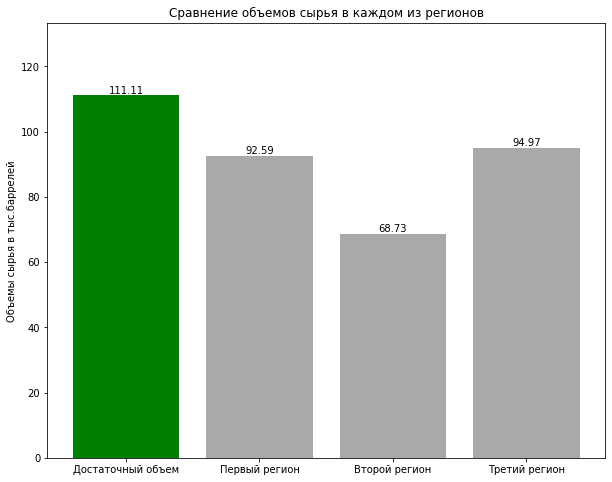

In [39]:
values = [NET_PROFIT_STUFF, predictions_one_mean, predictions_two_mean, predictions_three_mean]
labels = ['Достаточный объем', 'Первый регион', 'Второй регион', 'Третий регион']

fig, ax = plt.subplots(figsize=(10,8))

plt.bar(labels[0], values[0], color='green')
plt.bar(labels[1:], values[1:], color='darkgrey')

for i in range(len(labels)):
    ax.text(x = labels[i], y = values[i], s = f"{values[i]:.2f}", ha = 'center', va='bottom')

plt.ylabel('Объемы сырья в тыс.баррелей')
plt.title('Сравнение объемов сырья в каждом из регионов')

plt.ylim(top=max(values)*1.2)

plt.show()

In [40]:
print('Разница объема сырья в Первом регионе составляет:', round(predictions_one_mean-NET_PROFIT_STUFF, 2), 'т.б. ({:.2%})'.format(predictions_one_mean/NET_PROFIT_STUFF-1))
print('Разница объема сырья во Втором регионе составляет:', round(predictions_two_mean-NET_PROFIT_STUFF, 2), 'т.б. ({:.2%})'.format(predictions_two_mean/NET_PROFIT_STUFF-1))
print('Разница объема сырья в Третьем регионе составляет:', round(predictions_three_mean-NET_PROFIT_STUFF, 2), 'т.б. ({:.2%})'.format(predictions_three_mean/NET_PROFIT_STUFF-1))

Разница объема сырья в Первом регионе составляет: -18.52 т.б. (-16.67%)
Разница объема сырья во Втором регионе составляет: -42.38 т.б. (-38.14%)
Разница объема сырья в Третьем регионе составляет: -16.14 т.б. (-14.53%)


### Выводы

Запасов сырья в каждом из регионов недостаточно, чтобы окупить затраты на разработку

## Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

### Выберем скважины с максимальными значениями предсказаний

In [41]:
region_one_top_200 = sorted(predictions_one_valid, reverse=True)[:BEST_POINTS]
region_two_top_200 = sorted(predictions_two_valid, reverse=True)[:BEST_POINTS]
region_three_top_200 = sorted(predictions_three_valid, reverse=True)[:BEST_POINTS]

### Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям

In [42]:
print(f"Объем сырья 200 лучших скважин Первого региона составляет: {round(sum(region_one_top_200), 2)}")
print(f"Объем сырья 200 лучших скважин Второго региона составляет: {round(sum(region_two_top_200), 2)}")
print(f"Объем сырья 200 лучших скважин Третьего региона составляет: {round(sum(region_three_top_200), 2)}")


Объем сырья 200 лучших скважин Первого региона составляет: 31102.33
Объем сырья 200 лучших скважин Второго региона составляет: 27746.03
Объем сырья 200 лучших скважин Третьего региона составляет: 29603.9


### Рассчитайте прибыль для полученного объёма сырья

In [43]:
def net_profit_gainz(prediction, target, count):
    best_spots = sum(sorted(prediction, reverse=True)[:count])
    net_profit = (best_spots * UNIT_INCOME) - BUDGET
    print('Чистая прибыль составит %.2f'%(net_profit))

Прибыль для первого региона

In [44]:
net_profit_gainz(predictions_one_valid, target_one_valid, BEST_POINTS)

Чистая прибыль составит 3996048877.47


Прибыль для второго региона

In [45]:
net_profit_gainz(predictions_two_valid, target_two_valid, BEST_POINTS)

Чистая прибыль составит 2485712051.97


Прибыль для третьего региона

In [46]:
net_profit_gainz(predictions_three_valid, target_three_valid, BEST_POINTS)

Чистая прибыль составит 3321754396.24


## Посчитаем риски и прибыль для каждого региона

### Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

In [47]:
def net_profit_gainz_two(predict, target, count):
    probs_sorted = pd.Series(predict).sort_values(ascending=False)
    selected_points = target[probs_sorted.index][:count]
    product = selected_points.sum()
    revenue = product * UNIT_INCOME
    return revenue - BUDGET

<div class="alert alert-info">
Старая версия бутстрэп
</div>

In [48]:
def bootstap_1000(target,predict):
    values = []
    count=0
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)
    for i in tqdm(range(1000)):
        target_subsample = target.sample(n=TOTAL_POINTS,replace=True, random_state=state)
        probs_subsample = predict_e[target_subsample.index]
        values.append(net_profit_gainz_two(probs_subsample,target_subsample, BEST_POINTS))  
        
    for i in values:
        if i < 0:
            count +=1

    values = pd.Series(values)
    mean = values.mean()

    print("Средняя прибыль: {:.2f} млн.руб".format(mean/1000))
    print ('Риск убытка: {:.1%}'.format(count/1000))

<div class="alert alert-info">
Новая версия. будем использовать новую
</div>

In [49]:
def bootstrap_try_two(target, predict, num_resamples=1000):
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)
    values = []
    
    for i in range(num_resamples):
        target_subsample = target.sample(n=TOTAL_POINTS, replace=True, random_state=state)
        probs_subsample = predict_e[target_subsample.index]
        values.append(net_profit_gainz_two(probs_subsample, target_subsample, BEST_POINTS))  
    
    values = pd.Series(values)
    mean = values.mean()
    count = sum([1 for i in values if i < 0])

    low_95 = values.quantile(0.025)
    high_95 = values.quantile(0.975)

    print("Средняя прибыль: {:.2f} млн.руб".format(mean/1000))
    print('Риск убытка: {:.1%}'.format(count/1000))
    print("95%-ый доверительный интервал: от {:.2f} млн.руб до {:.2f} млн.руб". format((low_95/1000),(high_95/1000)))

Для первого региона

In [50]:
bootstrap_try_two(target_one_valid,predictions_one_valid);

Средняя прибыль: 425938.53 млн.руб
Риск убытка: 6.0%
95%-ый доверительный интервал: от -102090.09 млн.руб до 947976.35 млн.руб


Для второго региона

In [51]:
bootstrap_try_two(target_two_valid,predictions_two_valid);

Средняя прибыль: 515222.77 млн.руб
Риск убытка: 1.0%
95%-ый доверительный интервал: от 68873.23 млн.руб до 931547.59 млн.руб


Для третьего региона

In [52]:
bootstrap_try_two(target_three_valid,predictions_three_valid);

Средняя прибыль: 435008.36 млн.руб
Риск убытка: 6.4%
95%-ый доверительный интервал: от -128880.55 млн.руб до 969706.95 млн.руб


### Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль

In [53]:
def bootstrap_confidence_interval(target, predict, num_resamples=1000):
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)
    values = []
    
    for i in range(num_resamples):
        target_subsample = target.sample(n=TOTAL_POINTS, replace=True, random_state=state)
        probs_subsample = predict_e[target_subsample.index]
        values.append(net_profit_gainz_two(probs_subsample, target_subsample, BEST_POINTS))  
        
    values = pd.Series(values)
    mean = values.mean()
    #confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    low_95 = values.quantile(0.025)
    high_95 = values.quantile(0.975)
    
    print("95%-ый доверительный интервал: от {:.2f} млн.руб до {:.2f} млн.руб". format((low_95/1000),(high_95/1000)))

Для первого региона

In [54]:
bootstrap_confidence_interval(target_one_valid,predictions_one_valid)

95%-ый доверительный интервал: от -102090.09 млн.руб до 947976.35 млн.руб


Для второго региона

In [55]:
bootstrap_confidence_interval(target_two_valid,predictions_two_valid)

95%-ый доверительный интервал: от 68873.23 млн.руб до 931547.59 млн.руб


Для третьего региона

In [56]:
bootstrap_confidence_interval(target_three_valid,predictions_three_valid)

95%-ый доверительный интервал: от -128880.55 млн.руб до 969706.95 млн.руб


### Вывод

Нам были представлены датасеты геологический изысканий трех различных регионов.
<br>
мы проанализировали данные на входе, не нашли никаких ошибок или дубликатов, поняли, что представленные датасеты имеют одну структуру и один объем данных.
<br>
Мы использовали функцию <b>train_test_split</b> библиотеки scikit-learn для разделения каждого из представленных датасетов на обучающую и валидационную выборки.
<br>
Для каждой обучающей выборки мы удалили столбцы 'id' и 'product' и, согласно условию, использовали модель логистической регрессии для обучения моделей.
<br>
Затем мы проверили качество обученных моделей метрикой RMSE, вычислили среднее значение предсказанных значений.
<br>
<br>
Исходя из полученных результатов, регион с наибольшей средней прибылью и низким риском убытков (меньше 2.5%) является регионом номер два и этот регион является наиболее перспективным выбором для разработки нефтяных скважин.